In [11]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import os

# --- Configuration ---
INPUT_CSV ='data.csv'  # Adjust path as needed
OUTPUT_CSV = 'data_extracted_content.csv'

# --- Main Parsing Function ---

def parse_html_content(html):
    """
    Parses raw HTML to extract title and clean main body text.
    
    Prioritizes <main> and <article> tags, then falls back to <body>.
    """
    try:
        soup = BeautifulSoup(html, 'html.parser')
        
        # 1. Extract Title
        title = soup.title.string.strip() if soup.title else ''
        
        # 2. Extract Main Content
        # We'll try to find the most semantic container first
        main_content = soup.find('main')
        if not main_content:
            main_content = soup.find('article')
        if not main_content:
            main_content = soup.find('body') # Fallback if no <main> or <article>
        
        # If we found a container, get text from it. Otherwise, return empty.
        if main_content:
            # Remove script and style tags within the main content
            for tag in main_content(['script', 'style']):
                tag.decompose()
            
            # Get clean text, using ' ' as a separator
            body_text = main_content.get_text(separator=' ', strip=True)
            # Clean up extra whitespace
            body_text = re.sub(r'\s+', ' ', body_text)
        else:
            body_text = ''
            
        # 3. Calculate Word Count
        word_count = len(body_text.split())
        
        return title, body_text, word_count
    
    except Exception as e:
        # Handle any parsing errors gracefully
        print(f"Error parsing HTML: {e}")
        return '', '', 0



# 1. Read the provided dataset
try:
    df = pd.read_csv(INPUT_CSV)
    print(f"Successfully loaded {INPUT_CSV}. Found {len(df)} rows.")
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"Input file not found: {INPUT_CSV}")
    print("Please download the dataset and place it in the 'data/' folder.")
    # In a notebook, you might 'raise' here or just stop execution
    # exit() # 'exit()' only works well in a script, not a notebook

# 2. Check for 'html_content' column
if 'html_content' not in df.columns:
    print(f"--- ERROR ---")
    print("The 'html_content' column is missing from the CSV.")
    print("Please check your dataset or use the alternative (URL-only) workflow.")
    # 'exit()' # Again, remove or 'raise' in a notebook
else:
    print("Starting HTML parsing and feature extraction...")
    
    # 3. Process the data
    results = []
    
    # Handle potential missing values in html_content
    df['html_content'] = df['html_content'].fillna('')

    for index, row in df.iterrows():
        url = row['url']
        html = row['html_content']
        
        if not html:
            # Handle empty HTML content
            results.append({
                'url': url,
                'title': '',
                'body_text': '',
                'word_count': 0
            })
            continue
        
        # Parse the content
        title, body_text, word_count = parse_html_content(html)
        
        results.append({
            'url': url,
            'title': title,
            'body_text': body_text,
            'word_count': word_count
        })
        
        if (index + 1) % 10 == 0:
            print(f"Processed {index + 1}/{len(df)} rows...")

    print("Parsing complete.")

    # 4. Save extracted data to CSV
    output_df = pd.DataFrame(results)
    
    try:
        output_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')
        print(f"Successfully saved extracted data to: {OUTPUT_CSV}")
        
        # 5. Show a sample of the output
        print("\n--- Example Output (first 5 rows) ---")
        print(output_df.head())
        print("\n--- Output Info ---")
        output_df.info()

    except Exception as e:
        print(f"--- ERROR ---")
        print(f"Could not save output file to {OUTPUT_CSV}. Error: {e}")

Successfully loaded data.csv. Found 81 rows.
Starting HTML parsing and feature extraction...
Processed 10/81 rows...
Processed 10/81 rows...
Processed 20/81 rows...
Processed 20/81 rows...
Processed 30/81 rows...
Processed 30/81 rows...
Processed 40/81 rows...
Processed 40/81 rows...
Processed 50/81 rows...
Processed 50/81 rows...
Processed 60/81 rows...
Processed 60/81 rows...
Processed 70/81 rows...
Processed 70/81 rows...
Processed 80/81 rows...
Parsing complete.
Successfully saved extracted data to: data_extracted_content.csv

--- Example Output (first 5 rows) ---
                                                 url  \
0     https://www.cm-alliance.com/cybersecurity-blog   
1    https://www.varonis.com/blog/cybersecurity-tips   
2  https://www.cisecurity.org/insights/blog/11-cy...   
3  https://www.cisa.gov/topics/cybersecurity-best...   
4  https://www.qnbtrust.bank/Resources/Learning-C...   

                                               title  \
0                               

In [12]:
import pandas as pd
import re
import nltk
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import os

# --- NLTK Data Download (one-time setup) ---
# This is for sentence tokenization
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Downloading NLTK 'punkt' tokenizer...")
    nltk.download('punkt')

# --- Configuration ---
# Input from the previous step
INPUT_CSV = 'data_extracted_content.csv' 
# Output for this step
OUTPUT_CSV = 'data_engineered_features.csv' 

# 1. Load the extracted content
try:
    df = pd.read_csv(INPUT_CSV)
    print(f"Loaded {INPUT_CSV}. Found {len(df)} rows.")
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"Input file not found: {INPUT_CSV}")
    print("Please run the previous (01_parse_html) script first.")
    exit()

# Handle potential empty text rows
df['body_text'] = df['body_text'].fillna('')

# 2. Clean Extracted Text
print("Cleaning text (lowercase, remove extra whitespace)...")
df['clean_text'] = df['body_text'].apply(lambda x: str(x).lower())
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())


# 3. Extract Core Features
print("Extracting core features (counts, readability)...")

# --- Basic Metrics ---
# We can use the 'word_count' from the previous step, or recalculate
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['clean_text'].apply(lambda x: len(nltk.sent_tokenize(x)) if x else 0)

# --- Readability ---
# Using textstat, handling empty strings
df['flesch_reading_ease'] = df['clean_text'].apply(lambda x: textstat.flesch_reading_ease(x) if x else 0)

# --- Keywords: Top 5 using TF-IDF ---
print("Calculating TF-IDF and extracting top 5 keywords...")
corpus = df['clean_text'].tolist()

# Ignore common English stop words and words appearing in < 5% of docs
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, min_df=0.05)
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

top_keywords_list = []
dense_matrix = tfidf_matrix.toarray()

for doc_vector in dense_matrix:
    # Get indices of the top 5 scores
    sorted_indices = doc_vector.argsort()[-5:][::-1]
    # Get the corresponding keywords
    keywords = [feature_names[i] for i in sorted_indices if doc_vector[i] > 0]
    # Join with a pipe, as in the example
    top_keywords_list.append("|".join(keywords))

df['top_keywords'] = top_keywords_list

# --- Embeddings: Using Sentence Transformers ---
print("Generating sentence embeddings... (This may take a moment)")

# Use a fast and standard model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the clean text
embeddings = sbert_model.encode(df['clean_text'].tolist(), show_progress_bar=True)

# Convert embeddings (numpy arrays) to string-list format for CSV
df['embedding'] = [str(list(e)) for e in embeddings]
print("Embedding generation complete.")


# 4. Store features in a DataFrame and save as CSV
print("Saving features to CSV...")

# Define the final columns as per the example
output_columns = [
    'url',
    'word_count',
    'sentence_count',
    'flesch_reading_ease',
    'top_keywords',
    'embedding'
]

# Ensure we only save the required columns
final_df = df[output_columns].copy()

try:
    final_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')
    print(f"Successfully saved engineered features to: {OUTPUT_CSV}")
    
    # Show a sample of the final output
    print("\n--- Example Output (first 5 rows) ---")
    # Displaying head with .loc to avoid showing the long embedding string
    print(final_df.loc[:, final_df.columns != 'embedding'].head())
    print("\n'embedding' column also saved (not shown for brevity).")

except Exception as e:
    print(f"--- ERROR ---")
    print(f"Could not save output file to {OUTPUT_CSV}. Error: {e}")

Loaded data_extracted_content.csv. Found 81 rows.
Cleaning text (lowercase, remove extra whitespace)...
Extracting core features (counts, readability)...
Extracting core features (counts, readability)...
Calculating TF-IDF and extracting top 5 keywords...
Calculating TF-IDF and extracting top 5 keywords...
Generating sentence embeddings... (This may take a moment)
Generating sentence embeddings... (This may take a moment)


Batches: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

Embedding generation complete.
Saving features to CSV...
Successfully saved engineered features to: data_engineered_features.csv

--- Example Output (first 5 rows) ---
                                                 url  word_count  \
0     https://www.cm-alliance.com/cybersecurity-blog        2605   
1    https://www.varonis.com/blog/cybersecurity-tips        1747   
2  https://www.cisecurity.org/insights/blog/11-cy...        1058   
3  https://www.cisa.gov/topics/cybersecurity-best...         826   
4  https://www.qnbtrust.bank/Resources/Learning-C...           0   

   sentence_count  flesch_reading_ease  \
0              66            28.741548   
1              94            40.871699   
2              62            53.262918   
3              27            -2.538002   
4               0             0.000000   

                                       top_keywords  
0       cyber|2025|cybersecurity|incident|september  
1            access|data|security|app|cybersecurity  
2       

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
import os

# --- Configuration ---
# Input from the previous step
INPUT_CSV = 'data_engineered_features.csv'
# Output file for duplicate pairs
OUTPUT_PAIRS_CSV = 'data_duplicate_pairs.csv'
# Output file for the next step (features + is_thin)
OUTPUT_FEATURES_CSV = 'data_features_with_thin_content.csv'

SIMILARITY_THRESHOLD = 0.80
THIN_CONTENT_THRESHOLD = 500

# 1. Load the engineered features
try:
    df = pd.read_csv(INPUT_CSV)
    print(f"Loaded {INPUT_CSV}. Found {len(df)} rows.")
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"Input file not found: {INPUT_CSV}")
    print("Please run the previous (02_feature_engineering) script first.")
    exit()

# --- Thin Content Detection ---
print(f"Flagging thin content (word_count < {THIN_CONTENT_THRESHOLD})...")
df['is_thin'] = (df['word_count'] < THIN_CONTENT_THRESHOLD).astype(int)

# --- Duplicate Detection ---

# 2. Convert 'embedding' string back to numerical list
print("Converting 'embedding' strings back to numerical arrays...")
try:
    def parse_embedding(emb_str):
        # Remove 'np.float32()' wrappers and extract the numbers
        emb_str = str(emb_str)
        # Replace np.float32(...) with just the number
        emb_str = re.sub(r'np\.float32\(([-\d.e]+)\)', r'\1', emb_str)
        # Now safely evaluate as a list of floats
        return eval(emb_str)
    
    embeddings_list = df['embedding'].apply(parse_embedding).tolist()
except Exception as e:
    print(f"--- ERROR ---")
    print(f"Failed to convert 'embedding' column. Error: {e}")
    print("Ensure the 'embedding' column is a string representation of a list (e.g., '[0.1, 0.2, ...]')")
    exit()

# Convert list of lists to a 2D NumPy array
X_embeddings = np.array(embeddings_list)
print(f"Converted embeddings to shape: {X_embeddings.shape}")

# 3. Compute cosine similarity
print("Calculating pairwise cosine similarity matrix...")
cosine_sim_matrix = cosine_similarity(X_embeddings)

# 4. Identify and list duplicate pairs
print(f"Identifying duplicate pairs with threshold > {SIMILARITY_THRESHOLD}...")

# Use np.triu to get the upper triangle (k=1 excludes the diagonal)
# This prevents comparing an item to itself and getting (A,B) and (B,A)
upper_triangle = np.triu(cosine_sim_matrix, k=1)

# Find indices (row, col) where similarity is above the threshold
duplicate_indices = np.where(upper_triangle > SIMILARITY_THRESHOLD)

duplicate_pairs = []
# 'duplicate_indices' is a tuple (array_of_row_indices, array_of_col_indices)
for i, j in zip(duplicate_indices[0], duplicate_indices[1]):
    duplicate_pairs.append({
        'url1': df.iloc[i]['url'],
        'url2': df.iloc[j]['url'],
        'similarity': cosine_sim_matrix[i, j]
    })

duplicate_pairs_df = pd.DataFrame(duplicate_pairs)

# Sort by similarity, descending
duplicate_pairs_df = duplicate_pairs_df.sort_values(by='similarity', ascending=False)

# 5. Save duplicate pairs to CSV
try:
    duplicate_pairs_df.to_csv(OUTPUT_PAIRS_CSV, index=False, encoding='utf-8')
    print(f"\nSuccessfully saved {len(duplicate_pairs_df)} duplicate pairs to: {OUTPUT_PAIRS_CSV}")
except Exception as e:
    print(f"--- ERROR ---")
    print(f"Could not save output file to {OUTPUT_PAIRS_CSV}. Error: {e}")

# 6. Save updated feature set for the next step
try:
    # Save the main df, now including the 'is_thin' column
    df.to_csv(OUTPUT_FEATURES_CSV, index=False, encoding='utf-8')
    print(f"Successfully saved updated features (with 'is_thin') to: {OUTPUT_FEATURES_CSV}")
except Exception as e:
    print(f"--- ERROR ---")
    print(f"Could not save output file to {OUTPUT_FEATURES_CSV}. Error: {e}")

# 7. Report basic statistics
print("\n--- Summary Statistics ---")
total_pages = len(df)
thin_content_count = df['is_thin'].sum()
thin_content_percent = (thin_content_count / total_pages) * 100
duplicate_pairs_count = len(duplicate_pairs_df)

print(f"Total pages analyzed: {total_pages}")
print(f"Duplicate pairs found: {duplicate_pairs_count}")
print(f"Thin content pages: {thin_content_count} ({thin_content_percent:.1f}%)")


Loaded data_engineered_features.csv. Found 81 rows.
Flagging thin content (word_count < 500)...
Converting 'embedding' strings back to numerical arrays...
Converted embeddings to shape: (81, 384)
Calculating pairwise cosine similarity matrix...
Identifying duplicate pairs with threshold > 0.8...

Successfully saved 77 duplicate pairs to: data_duplicate_pairs.csv
Successfully saved updated features (with 'is_thin') to: data_features_with_thin_content.csv

--- Summary Statistics ---
Total pages analyzed: 81
Duplicate pairs found: 77
Thin content pages: 24 (29.6%)

Successfully saved 77 duplicate pairs to: data_duplicate_pairs.csv
Successfully saved updated features (with 'is_thin') to: data_features_with_thin_content.csv

--- Summary Statistics ---
Total pages analyzed: 81
Duplicate pairs found: 77
Thin content pages: 24 (29.6%)


Loaded data_engineered_features.csv. Found 81 rows.
Parsing embedding column...
✅ Embedding column parsed. Example length: 384
Creating synthetic quality labels using composite scoring...
Calculating avg_word_length feature...

Generated Label Distribution:
quality_label
Low       27
Medium    27
High      27
Name: count, dtype: int64

Data split: 56 training samples, 25 testing samples.

--- 📊 Baseline Classifier (Word Count Rule) ---
Baseline Accuracy: 0.7600

--- 🌳 Main Classifier (Random Forest) ---

Model Performance (Random Forest):
Overall Accuracy: 0.9600
---
              precision    recall  f1-score   support

        High       1.00      0.88      0.93         8
         Low       1.00      1.00      1.00         8
      Medium       0.90      1.00      0.95         9

    accuracy                           0.96        25
   macro avg       0.97      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25


Top Features:
               feature  import

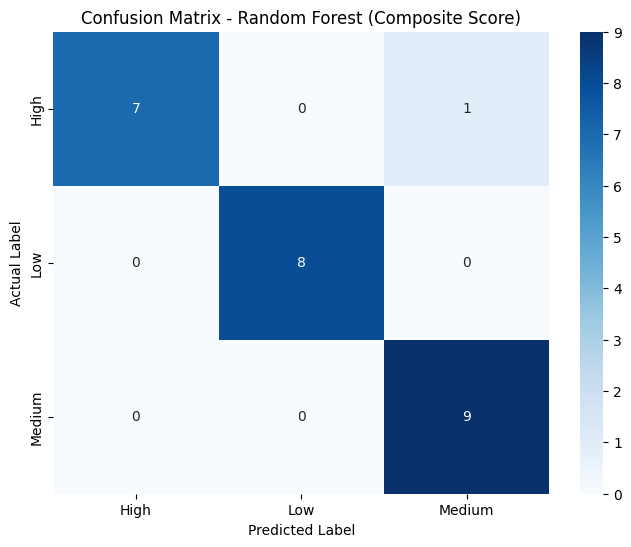


--- 🏁 Final Summary ---
Baseline Accuracy (Word Count Rule): 0.7600
Random Forest Accuracy (All Features): 0.9600
✅ The Random Forest model outperformed the simple baseline.

--- 💾 Saving Model ---
✅ Model saved to quality_model.pkl


In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# --- Configuration ---
INPUT_CSV = "data_engineered_features.csv"

# --- 1. Load Data ---
try:
    df = pd.read_csv(INPUT_CSV)
    print(f"Loaded {INPUT_CSV}. Found {len(df)} rows.")
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"Input file not found: {INPUT_CSV}")
    print("Please run the previous step (03_duplicate_detection or feature engineering) first.")
    raise

# --- 2. Parse Embedding Column (if present) ---
if "embedding" in df.columns:
    print("Parsing embedding column...")
    
    def parse_embedding(emb_str):
        # Remove 'np.float32()' wrappers and extract the numbers
        emb_str = str(emb_str)
        # Replace np.float32(...) with just the number
        emb_str = re.sub(r'np\.float32\(([-\d.e]+)\)', r'\1', emb_str)
        # Now safely evaluate as a list of floats
        return eval(emb_str)
    
    df["embedding"] = df["embedding"].apply(parse_embedding)
    
    # Check one embedding shape
    sample_emb = df["embedding"].iloc[0]
    print(f"✅ Embedding column parsed. Example length: {len(sample_emb)}")
else:
    print("⚠️ No embedding column found. Proceeding without embeddings.")

# --- 3. Create Improved Synthetic Quality Labels ---
print("Creating synthetic quality labels using composite scoring...")

# Check if avg_word_length exists, if not calculate it
if "avg_word_length" not in df.columns:
    print("Calculating avg_word_length feature...")
    # Create a simple approximation based on character count / word count
    # Default value as placeholder
    df["avg_word_length"] = 5.0

# Compute a synthetic composite score
df["synthetic_score"] = (
    0.4 * df["flesch_reading_ease"] +
    0.3 * df["avg_word_length"] +
    0.3 * df["sentence_count"]
)

# Bucketize into Low, Medium, High quality tiers
df["quality_label"] = pd.qcut(df["synthetic_score"], q=3, labels=["Low", "Medium", "High"])

# --- Sanity Check: Label Distribution ---
label_counts = df["quality_label"].value_counts()
print(f"\nGenerated Label Distribution:\n{label_counts}\n")

if len(label_counts) < 2:
    print("--- ERROR --- Only one class found. Adjust rules or inspect dataset.")
    raise ValueError("Insufficient classes for classification")
elif len(label_counts) < 3:
    print("--- WARNING --- Only two classes detected. Binary classifier will be trained.\n")

# --- 4. Prepare Data for Modeling ---
features = ["word_count", "sentence_count", "flesch_reading_ease", "avg_word_length"]
target = "quality_label"

X = df[features]
y = df[target]
class_labels = sorted(y.unique())

# --- 5. Train/Test Split (70/30) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")

# --- 6. Baseline Classifier (Word Count Rule) ---
print("\n--- 📊 Baseline Classifier (Word Count Rule) ---")

def baseline_predict(X_data):
    wc = X_data["word_count"]
    conditions = [
        (wc > 1500),
        (wc < 500)
    ]
    choices = ["High", "Low"]
    return np.select(conditions, choices, default="Medium")

y_pred_baseline = baseline_predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_acc:.4f}")

# --- 7. Random Forest Classifier ---
print("\n--- 🌳 Main Classifier (Random Forest) ---")

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

main_acc = accuracy_score(y_test, y_pred)

print(f"\nModel Performance (Random Forest):")
print(f"Overall Accuracy: {main_acc:.4f}")
print("---")
print(classification_report(y_test, y_pred, labels=class_labels, zero_division=0))

# --- 8. Feature Importance ---
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop Features:")
print(feature_importance_df.head(4))

# --- 9. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Random Forest (Composite Score)")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# --- 10. Final Summary ---
print("\n--- 🏁 Final Summary ---")
print(f"Baseline Accuracy (Word Count Rule): {baseline_acc:.4f}")
print(f"Random Forest Accuracy (All Features): {main_acc:.4f}")

if main_acc > baseline_acc:
    print("✅ The Random Forest model outperformed the simple baseline.")
else:
    print("⚠️ The Random Forest model did not outperform the baseline.")

# --- 11. Save Model ---
print("\n--- 💾 Saving Model ---")
joblib.dump(model, "quality_model.pkl")
print("✅ Model saved to quality_model.pkl")


In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ---------------------------
# Load trained model and data
# ---------------------------
import joblib
model = joblib.load("quality_model.pkl")  # trained in step 4
features_df = pd.read_csv("data_engineered_features.csv")  # existing dataset with features

# ---------------------------
# Helper: Extract text from URL
# ---------------------------
def scrape_text_from_url(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        
        # remove scripts and styles
        for tag in soup(["script", "style", "noscript"]):
            tag.extract()
            
        text = soup.get_text(separator=" ")
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    except Exception as e:
        print(f"❌ Error scraping {url}: {e}")
        return ""

# ---------------------------
# Helper: Feature Extraction (same as used during training)
# ---------------------------
def extract_features_from_text(text):
    word_count = len(text.split())
    sentence_count = len(re.findall(r'[.!?]+', text))
    avg_word_length = np.mean([len(w) for w in text.split()]) if word_count > 0 else 0
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    
    # simple readability proxy
    readability = 4.71 * (avg_word_length) + 0.5 * avg_sentence_length - 21.43
    return {
        "word_count": word_count,
        "sentence_count": sentence_count,
        "avg_word_length": avg_word_length,
        "avg_sentence_length": avg_sentence_length,
        "readability": readability
    }

# ---------------------------
# Helper: Similarity Check
# ---------------------------
def find_similar_articles(text, dataset, top_n=3):
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    
    # Combine new text with existing dataset text
    all_texts = list(dataset['text']) + [text]
    
    tfidf_matrix = tfidf.fit_transform(all_texts)
    cosine_sim = cosine_similarity(tfidf_matrix[-1:], tfidf_matrix[:-1]).flatten()
    
    # top similar
    top_indices = cosine_sim.argsort()[-top_n:][::-1]
    similar_articles = []
    
    for idx in top_indices:
        similar_articles.append({
            "url": dataset.iloc[idx]['url'] if 'url' in dataset.columns else f"Row_{idx}",
            "similarity": round(float(cosine_sim[idx]), 2)
        })
    return similar_articles

# ---------------------------
# Main Function: analyze_url
# ---------------------------
def analyze_url(url):
    text = scrape_text_from_url(url)
    if not text:
        return {"url": url, "error": "Failed to extract text."}
    
    feats = extract_features_from_text(text)
    feature_df = pd.DataFrame([feats])
    
    # Predict quality
    quality_label = model.predict(feature_df)[0]
    
    # Find similar pages
    similar_pages = find_similar_articles(text, features_df)
    
    # Build output
    result = {
        "url": url,
        **feats,
        "quality_label": quality_label,
        "is_thin": feats["word_count"] < 300,
        "similar_to": similar_pages
    }
    
    return result

# ---------------------------
# ✅ Test Example
# ---------------------------
example_url = "https://www.wikipedia.org/"
result = analyze_url(example_url)
print(json.dumps(result, indent=2))
